# Variational Autoencoder (VAE)

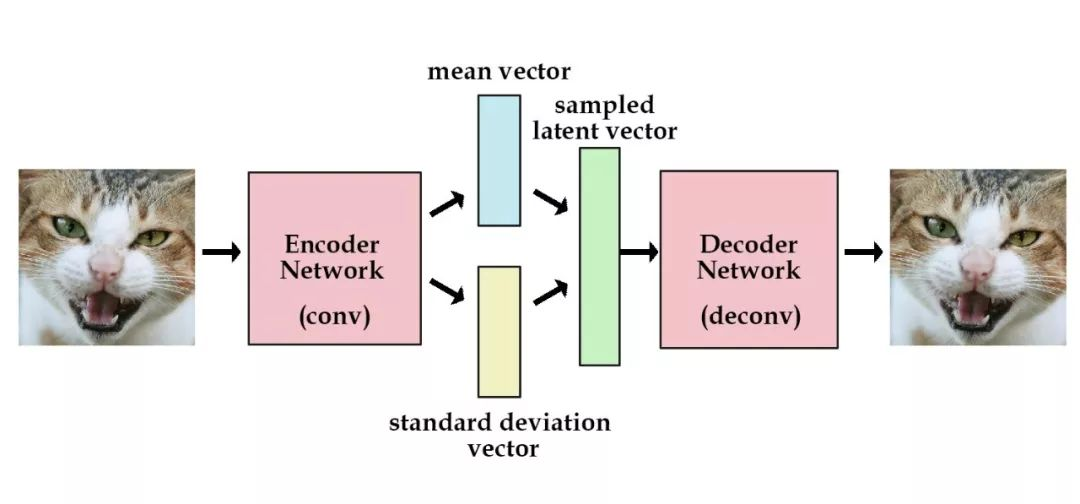

# <font color='green'>0. Импорт необходимых модулей</font>  

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Для создания и обучения нейронных сетей
import torch
from torch import nn, optim
import torch.nn.functional as F

# Для загрузки датасетов
from torch.utils.data import Dataset, DataLoader 

# Для обработки данных
import torchvision
import torchvision.transforms as TF 
from torchvision.utils import make_grid # Для вывода набора изображений
from torchvision.utils import save_image

from IPython import display
from IPython.display import clear_output
from tqdm.auto import tqdm # для вывода на экран прогресса обучения

 Выбранный device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# <font color='green'>1. Препроцессинг данных</font>  

Датасет цифирек MNIST

Инструкция https://pytorch.org/vision/stable/datasets.html

Зададим **batch_size** (=сколько картинок будем брать за раз).

Каждую картинку сразу отобразим **преобразованием** (из transforms) в Torch Tensor.


In [ ]:
BATCH_SIZE = 32
transform = TF.ToTensor()

Загружаем датасет

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)

Чтобы подавать картики создадит объект класса **Dataloader**

Указываем:

*   Dataset откуда берётся данные
*   Batch_size = сколько картинок брать за раз
*   Shuffle = Нужно ли их перемешивать
*   Num_workers = сколько параллельных процессов создать (обычно число ядер у процессора) 

In [ ]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Количество изображений в dataloader - команда len:

In [ ]:
len(dataloader)

1875

По dataloader можно итерироваться. Получим одно из отображений из MNIST

In [ ]:
for X, y in dataloader:
  print(X.shape, y.shape)
  print(y)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])


Посмотрим на цифры

In [ ]:
from itertools import islice

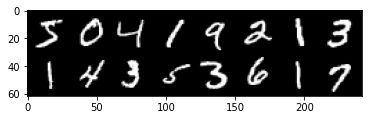

In [ ]:
images, _ = list(islice(dataloader, 1))[0]
plt.imshow(make_grid(images[:16], nrow=8).permute(1, 2, 0))
plt.show()

Точно также загрузим тестовый датасет

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# <font color='green'>2. VAE</font>   


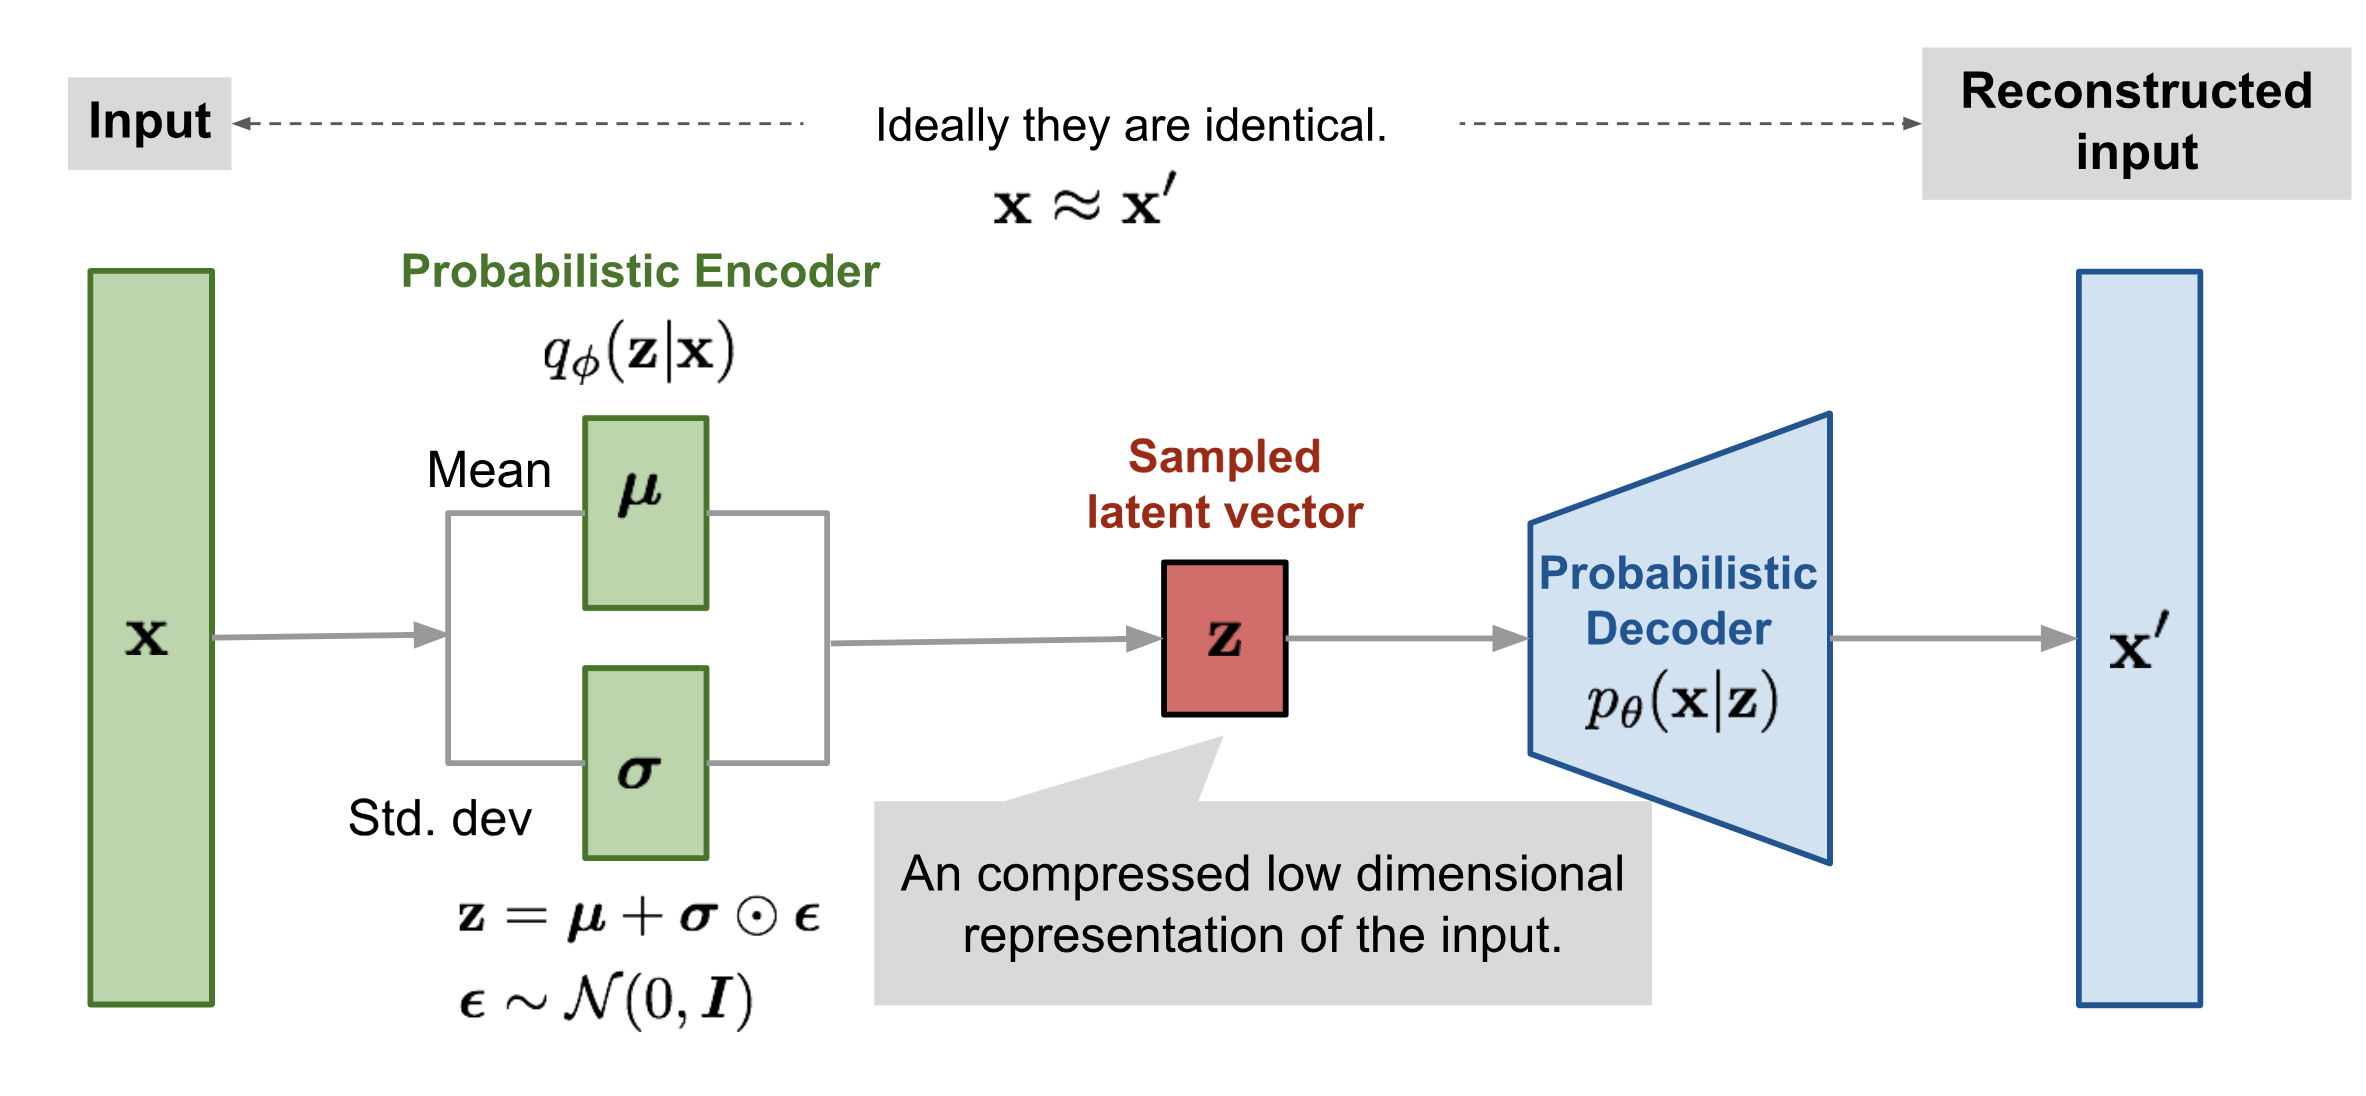

Можно рассматривать самые различные энкодеры и декодеры.

Один из самых простых вариантов - взять пару MLP, как на схеме низу.

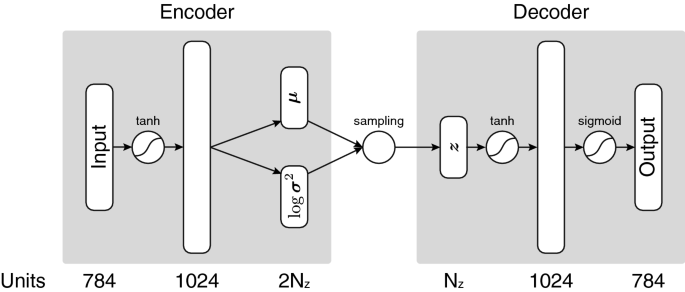

# **Замечания**

1.   Размеры слоёв, латентного пространства, типы функций активации и архитектуру можно менять.
2.   Для простоты **можно сэмплировать один z**
3.   Декодер для простоты предсказыват *объект, а не вероятность*. 
4.   Энкодер предсказывает <font color='red'> предсказывает logsimga, а не sigma </font>.

Дисперсия $\sigma^2 >0$. Это положительная функция, у которой производная в нуле равна 0. Для стабильности обучения лучше предсказывать вещественное число, а не положительное.



## <font color='blue'>2.1 Создаём VAE (10 баллов) </font>   

In [ ]:
# dimension of latent space
dimZ = 100

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        hid_dim = 1024
        self.fc1 = nn.Linear(784, hid_dim)
        self.fc21 = nn.Linear(hid_dim, dimZ)
        self.fc22 = nn.Linear(hid_dim, dimZ)
        self.fc3 = nn.Linear(dimZ, hid_dim)
        self.fc4 = nn.Linear(hid_dim, 784)

    def encode(self, x):
        h1 = torch.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# <font color='green'>3. Обучаем нейронную сеть</font>  

## <font color='blue'>3.1 Функция потерь (5 баллов)</font>  

Наша цель --- **минимизировать** следующий лосс:

$$\mathcal{L} = -\log p_{\theta}(x|z) + 
\operatorname{KL}(q_{\phi}(z|x)||p(z))  \to \min$$

*   В качестве 1го слагаемое - правдоподобия - мы возьмём кросс-энтропию. 
*   2ое слагаемое - это KL-дивергенция
$$\operatorname{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

Не забудь, что энкодер предсказывает <font color='red'> предсказывает logsimga, а не sigma </font>.

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  <font color='green'>3.2 Функции для обучения </font>  


In [ ]:
def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for iteration, (batch, _) in tqdm(enumerate(loader)):
        batch = batch.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(batch)
        loss = criterion(batch, reconstruction, mu, logvar)
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())   
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for iteration, (batch, _) in tqdm(enumerate(loader)):
          batch = batch.to(device)
          reconstruction, mu, logvar = model(batch)
          loss = criterion(batch, reconstruction, mu, logvar)
          losses_val.append(loss.item()) 
    return np.mean(losses_val)

In [ ]:
def learning_loop(model, optimizer, train_loader, val_loader, criterion, epochs=10, 
                  val_every=1, draw_every=1, separate_show=False):
  
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)
        
        # Валидируем и сохраняем лосс каждые val_every эпох
        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)

        # Рисуем график каждые draw_every шагов
        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
    return model, optimizer, losses

##  <font color='green'>3.3 Процесс обучения</font>  

In [ ]:
vae = VAE().to(device)
criterion = loss_function
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 10

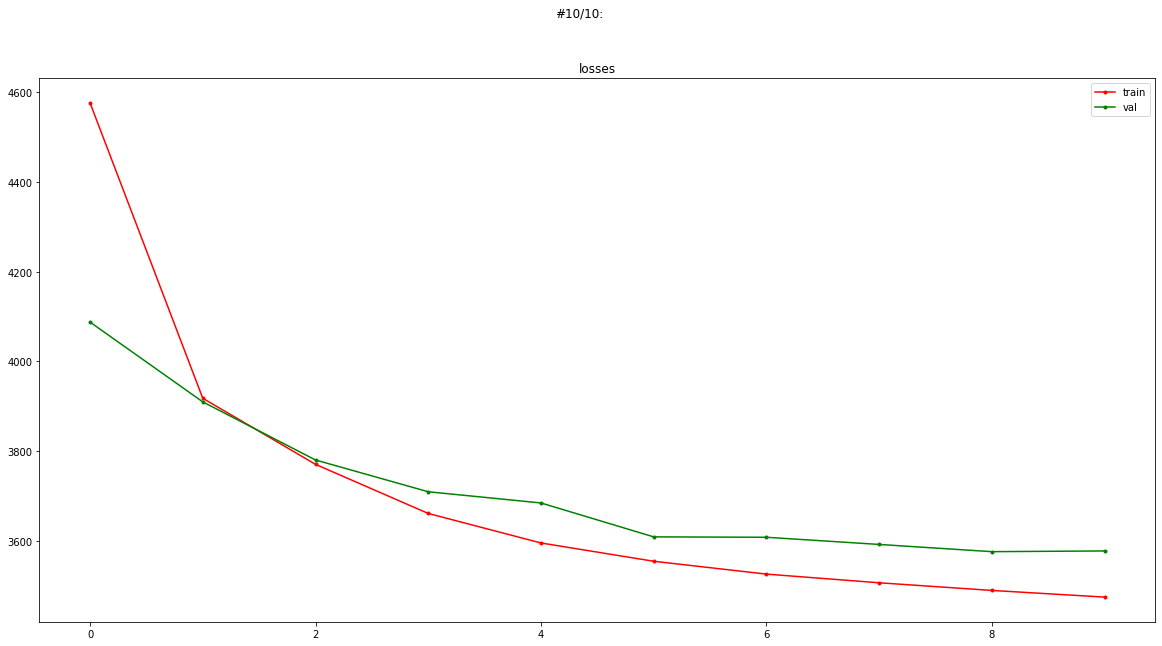

In [ ]:
vae, optimizer, losses = learning_loop(
    model = vae,
    optimizer = optimizer,
    train_loader = dataloader,
    val_loader = testloader,
    criterion =  criterion,
    epochs = num_epochs,
  )

# <font color='green'>4. Посмотрим на результат</font> 

In [ ]:
from itertools import islice

Загрузим серию картинок

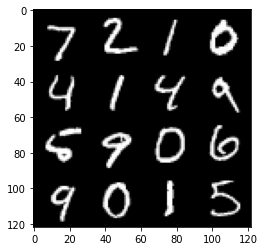

In [ ]:
images, _ = list(islice(testloader, 1))[0]
plt.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
plt.show()

Применим VAE

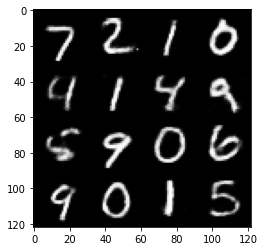

In [ ]:
reconstruction, mu, logsigma = vae(images.to(device))
reconstruction = reconstruction.cpu()
reconstruction = reconstruction.view(-1, 1, 28, 28)
plt.imshow(make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))
plt.show()

# <font color='blue'>5. Сэмплирование (5 баллов) </font> 

Сэплируйте и нарисуйте 25 цифр при помощи декодера

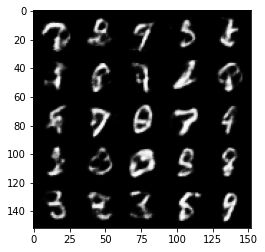

In [ ]:
z = torch.randn(25, dimZ) 
z = z.to(device)
reconstruction = vae.decode(z).view(-1, 1, 28, 28)
plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
plt.show()